# Multivariate LSTM Time Series Stock Prediction - AAPL

Stock Prediction of AAPL using LSTM with multiple features.

**Data source:** Yahoo Finance

**Features:** Stock data of AAPL
>`AAPL_Open`, `AAPL_High`, `AAPL_Low`, `AAPL_Close`, `AAPL_Volume`

**Train/Test:** 0.80 / 0.20

**Reference:** https://www.relataly.com/stock-market-prediction-using-multivariate-time-series-in-python/1815/#h-implementing-a-multivariate-time-series-prediction-model-in-python

### Setup

In [1]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from keras.models import Sequential # Deep learning library, used for neural networks
from keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from keras.callbacks import EarlyStopping # EarlyStopping during model training

# This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 

import seaborn as sns

### Step #1 Load the Time Series Data


In [2]:
df=pd.read_csv("Cleaned_Data_Stock_Prediction.csv")
df

,Date,NASDAQ_Comp_Open,NASDAQ_Comp_High,NASDAQ_Comp_Low,NASDAQ_Comp_Close,NASDAQ_Comp_Adj Close,NASDAQ_Comp_Volume,NASDAQ_Comp_%_Daily_Return,NASDAQ_Comp_Yesterday_Price_Change,NASDAQ_Comp_%_Daily_Change,...,CAD_USD_Daily_Change,CAD_USD_tmr_Change,DayOfWeek,Year,Month,Season,Autumn,Spring,Summer,Winter
0,2012-06-01,2810.129883,2810.129883,2747.239990,2747.479980,2747.479980,1.966370e+09,-0.960052,0.0,-0.022248,...,1.0,1.0,5,2012,6,Summer,0.0,0.0,1.0,0.0
1,2012-06-04,2747.610107,2769.929932,2726.679932,2760.010010,2760.010010,1.755750e+09,-2.224800,0.0,0.000633,...,0.0,0.0,1,2012,6,Summer,0.0,0.0,1.0,0.0
2,2012-06-05,2749.350098,2781.969971,2749.340088,2778.110107,2778.110107,1.625600e+09,0.063327,1.0,0.017051,...,0.0,0.0,2,2012,6,Summer,0.0,0.0,1.0,0.0
3,2012-06-06,2796.229980,2844.719971,2796.229980,2844.719971,2844.719971,1.761050e+09,1.705126,1.0,0.027115,...,0.0,0.0,3,2012,6,Summer,0.0,0.0,1.0,0.0
4,2012-06-07,2872.050049,2873.590088,2827.820068,2831.020020,2831.020020,1.655370e+09,2.711510,1.0,-0.016793,...,0.0,0.0,4,2012,6,Summer,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2262,2021-06-24,14357.269530,14414.459960,14333.700200,14369.709960,14369.709960,4.297280e+09,0.658257,1.0,0.003033,...,1.0,1.0,4,2021,6,Summer,0.0,0.0,1.0,0.0
2263,2021-06-25,14400.809570,14409.080080,14337.650390,14360.389650,14360.389650,7.436800e+09,0.303261,1.0,0.001180,...,0.0,0.0,5,2021,6,Summer,0.0,0.0,1.0,0.0
2264,2021-06-28,14417.809570,14505.190430,14417.200200,14500.509770,14500.509770,4.235620e+09,0.118049,1.0,0.006338,...,1.0,1.0,1,2021,6,Summer,0.0,0.0,1.0,0.0
2265,2021-06-29,14509.190430,14535.969730,14471.379880,14528.330080,14528.330080,4.842860e+09,0.633805,1.0,0.000045,...,1.0,1.0,2,2021,6,Summer,0.0,0.0,1.0,0.0


In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2267 entries, 0 to 2266
Data columns (total 347 columns):
 #    Column                                          Dtype  
---   ------                                          -----  
 0    Date                                            object 
 1    NASDAQ_Comp_Open                                float64
 2    NASDAQ_Comp_High                                float64
 3    NASDAQ_Comp_Low                                 float64
 4    NASDAQ_Comp_Close                               float64
 5    NASDAQ_Comp_Adj Close                           float64
 6    NASDAQ_Comp_Volume                              float64
 7    NASDAQ_Comp_%_Daily_Return                      float64
 8    NASDAQ_Comp_Yesterday_Price_Change              float64
 9    NASDAQ_Comp_%_Daily_Change                      float64
 10   NASDAQ_Comp_Daily_Change                        float64
 11   NASDAQ_Comp_tmr_Change                          float64
 12   Dow_Jones_Open    

In [4]:
AAPL = pd.concat([df.filter(items=['Date']), df.filter(regex=r'^AAPL', axis=1)], axis=1)
AAPL = AAPL.set_index("Date")
AAPL.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AAPL_%_Daily_Return,AAPL_Yesterday_Price_Change,AAPL_%_Daily_Change,AAPL_Daily_Change,AAPL_tmr_Change
Date,,,,,,,,,,,
2012-06-01,20.327143,20.451786,20.018572,20.035357,17.155754,520987600.0,-1.994001,0.0,-0.013458,0.0,1.0
2012-06-04,20.053572,20.267857,19.589287,20.153214,17.256676,556995600.0,-1.345841,0.0,-0.000410,0.0,0.0
2012-06-05,20.045357,20.231071,19.940357,20.101070,17.212034,388214400.0,-0.040965,0.0,0.011581,1.0,1.0
2012-06-06,20.277500,20.494642,20.196428,20.409286,17.475945,401455600.0,1.158089,1.0,0.016767,1.0,1.0
2012-06-07,20.617500,20.618570,20.375000,20.418571,17.483891,379766800.0,1.676735,1.0,-0.009856,0.0,1.0


In [5]:
df.Date=pd.to_datetime(df.Date)

### Step #2 Explore the Data


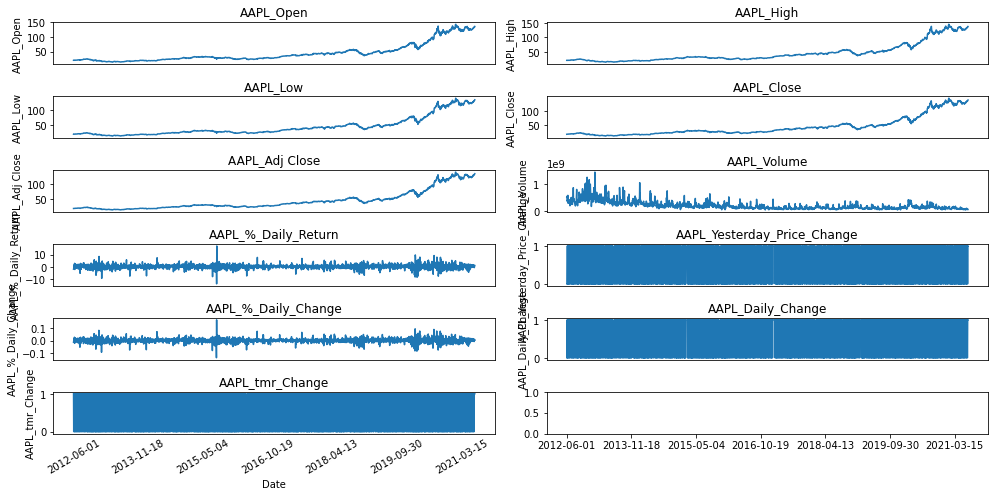

In [6]:
# Plot line charts
AAPL_plot = AAPL.copy()

list_length = AAPL_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=1, wspace=0.5)
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = AAPL.iloc[:, i], ax=ax)
        ax.set_title(AAPL.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

### Step #3 Scaling and Feature Selection

In [38]:
# Indexing Batches
train_df = AAPL.sort_values(by=['Date']).copy()

# We safe a copy of the dates index, before we need to reset it to numbers
date_index = train_df.index

# Adding Month and Year in separate columns
d = pd.to_datetime(train_df.index)
train_df['Month'] = d.strftime("%m")
train_df['Year'] = d.strftime("%Y") 

# We reset the index, so we can convert the date-index to a number-index
train_df = train_df.reset_index(drop=True).copy()
train_df.head(5)

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AAPL_%_Daily_Return,AAPL_Yesterday_Price_Change,AAPL_%_Daily_Change,AAPL_Daily_Change,AAPL_tmr_Change,Month,Year
0,20.327143,20.451786,20.018572,20.035357,17.155754,520987600.0,-1.994001,0.0,-0.013458,0.0,1.0,06,2012
1,20.053572,20.267857,19.589287,20.153214,17.256676,556995600.0,-1.345841,0.0,-0.000410,0.0,0.0,06,2012
2,20.045357,20.231071,19.940357,20.101070,17.212034,388214400.0,-0.040965,0.0,0.011581,1.0,1.0,06,2012
3,20.277500,20.494642,20.196428,20.409286,17.475945,401455600.0,1.158089,1.0,0.016767,1.0,1.0,06,2012
4,20.617500,20.618570,20.375000,20.418571,17.483891,379766800.0,1.676735,1.0,-0.009856,0.0,1.0,06,2012


In [41]:
# List of considered Features
FEATURES = ['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume',
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['AAPL_Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['AAPL_Open', 'AAPL_High', 'AAPL_Low', 'AAPL_Close', 'AAPL_Volume']


,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Volume,Prediction
2262,134.449997,134.639999,132.929993,133.410004,68711000.0,133.410004
2263,133.460007,133.889999,132.809998,133.110001,70783700.0,133.110001
2264,133.410004,135.250000,133.350006,134.779999,62111300.0,134.779999
2265,134.800003,136.490005,134.350006,136.330002,64556100.0,136.330002
2266,136.169998,137.410004,135.869995,136.960007,63261400.0,136.960007


In [42]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['AAPL_Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(2267, 5)


### Step #4 Transforming the Data

In [ ]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

In [ ]:
# Prediction Index
index_Close = data.columns.get_loc("AAPL_Close")

In [43]:
# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1764, 50, 5) (1764,)
(453, 50, 5) (453,)
0.06618941460959538
0.06618941460959538


### Step #5 Train the Multivariate Prediction Model

In [44]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

2022-02-17 21:02:40.245035: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


250 50 5


In [55]:
# Training the model
epochs = 10
batch_size = 16
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/10
111/111 [==============================] - 31s 277ms/step - loss: 6.1541e-05 - val_loss: 5.8152e-04
Epoch 2/10
111/111 [==============================] - 30s 266ms/step - loss: 5.2438e-05 - val_loss: 5.6117e-04
Epoch 3/10
111/111 [==============================] - 31s 279ms/step - loss: 4.7308e-05 - val_loss: 6.1978e-04
Epoch 4/10
111/111 [==============================] - 30s 273ms/step - loss: 5.7725e-05 - val_loss: 0.0027
Epoch 5/10
111/111 [==============================] - 36s 327ms/step - loss: 5.4046e-05 - val_loss: 0.0020
Epoch 6/10
111/111 [==============================] - 32s 284ms/step - loss: 4.5559e-05 - val_loss: 0.0013
Epoch 7/10
111/111 [==============================] - 37s 333ms/step - loss: 4.5444e-05 - val_loss: 4.3075e-04
Epoch 8/10
111/111 [==============================] - 31s 280ms/step - loss: 4.4680e-05 - val_loss: 0.0015
Epoch 9/10
111/111 [==============================] - 28s 253ms/step - loss: 4.2101e-05 - val_loss: 4.4156e-04
Epoch 10/10
111/1

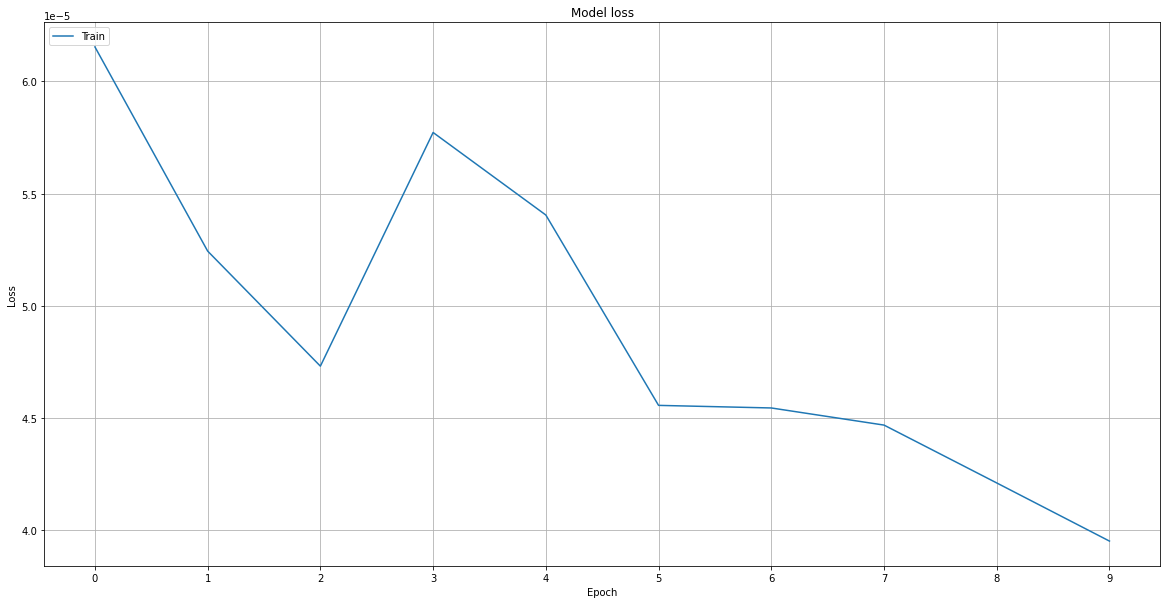

In [56]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

### Step #6 Evaluate Model Performance

In [57]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Median Absolute Error (MAE): 1.79
Mean Absolute Percentage Error (MAPE): 1.83 %
Median Absolute Percentage Error (MDAPE): 1.28 %


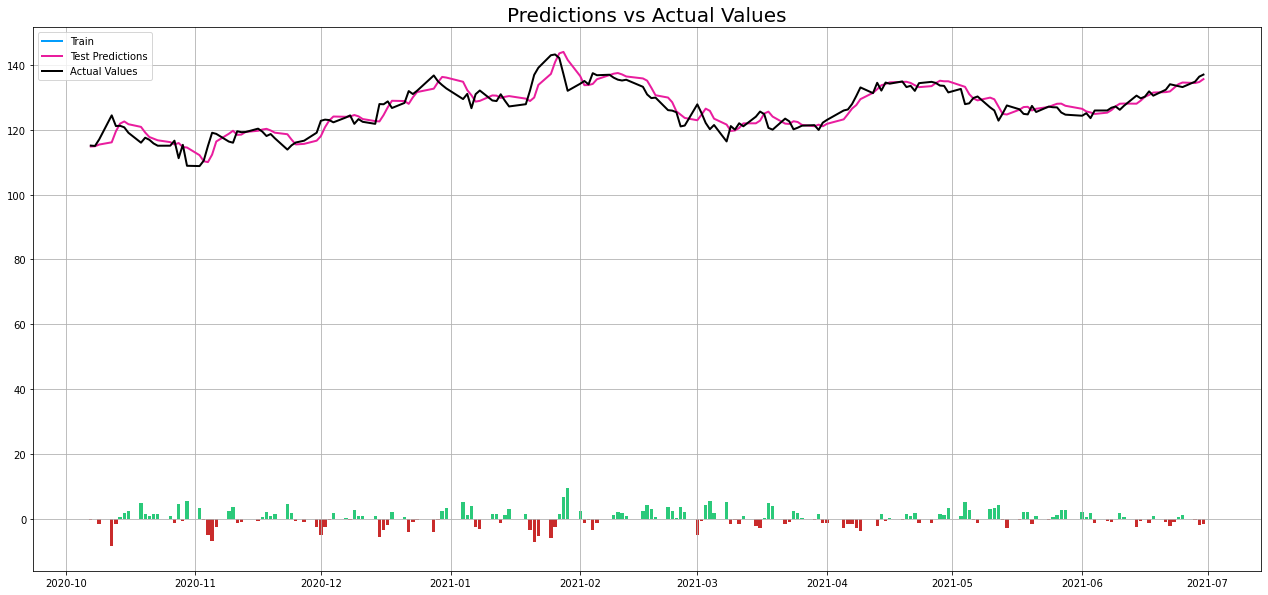

In [92]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=500)

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = date_index

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["AAPL_Close"], True)

# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["AAPL_Close"]]
xv = valid['Date']; yv = valid[["AAPL_Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
#plt.ylabel(stockname, fontsize=18)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["AAPL_Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()